<a href="https://colab.research.google.com/github/bryaanabraham/Digital_Image_Processing/blob/main/Model_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import joblib
from skimage.feature import greycomatrix, greycoprops
from PIL import Image
from IPython.display import display

In [22]:
def analyze_color(image):
  mean_color = np.mean(image, axis=(0, 1))
  return mean_color

In [23]:
def analyze_texture(image):
  gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  glcm = greycomatrix(gray_image, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
  contrast = greycoprops(glcm, 'contrast')[0, 0]
  energy = greycoprops(glcm, 'energy')[0, 0]
  return contrast, energy

In [24]:
def analyze_shape(image):
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)
  contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  shape_features = []

  for contour in contours:
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)

    if area != 0:
        compactness = (perimeter**2) / (4 * np.pi * area)
    else:
        compactness = 0

    rect = cv2.minAreaRect(contour)
    rect_area = rect[1][0] * rect[1][1]

    if rect_area != 0:
        extent = area / rect_area
    else:
        extent = 0

    hull = cv2.convexHull(contour)
    hull_area = cv2.contourArea(hull)

    if hull_area != 0:
        solidity = float(area) / hull_area
    else:
        solidity = 0

    shape_features.append({
        'Area': area,
        'Perimeter': perimeter,
        'Compactness': compactness,
        'Extent': extent,
        'Solidity': solidity
    })

  return shape_features

In [25]:
def process_image_for_features(image_path):
    image = cv2.imread(image_path)
    data = pd.DataFrame(columns=['r_color', 'g_color', 'b_color', 'contrast', 'energy', 'area', 'perimeter',
                                 'compactness', 'extent', 'solidity'])

    color_features = analyze_color(image)
    data.loc[0, 'r_color'] = color_features[0]
    data.loc[0, 'g_color'] = color_features[1]
    data.loc[0, 'b_color'] = color_features[2]

    texture_features = analyze_texture(image)
    data.loc[0, 'contrast'] = texture_features[0]
    data.loc[0, 'energy'] = texture_features[1]

    shape_features = analyze_shape(image)
    dictionary = shape_features[0]
    area = dictionary['Area']
    perimeter = dictionary['Perimeter']
    compactness = dictionary['Compactness']
    extent = dictionary['Extent']
    solidity = dictionary['Solidity']

    data.loc[0, 'area'] = area
    data.loc[0, 'perimeter'] = perimeter
    data.loc[0, 'compactness'] = compactness
    data.loc[0, 'extent'] = extent
    data.loc[0, 'solidity'] = solidity

    return data

In [26]:
def process_image_for_features(image_path):
    image = cv2.imread(image_path)
    data = pd.DataFrame(columns=['r_color', 'g_color', 'b_color', 'contrast', 'energy', 'area', 'perimeter',
                                 'compactness', 'extent', 'solidity'])

    color_features = analyze_color(image)
    data.loc[0, 'r_color'] = color_features[0]
    data.loc[0, 'g_color'] = color_features[1]
    data.loc[0, 'b_color'] = color_features[2]

    texture_features = analyze_texture(image)
    data.loc[0, 'contrast'] = texture_features[0]
    data.loc[0, 'energy'] = texture_features[1]

    shape_features = analyze_shape(image)
    dictionary = shape_features[0]
    area = dictionary['Area']
    perimeter = dictionary['Perimeter']
    compactness = dictionary['Compactness']
    extent = dictionary['Extent']
    solidity = dictionary['Solidity']

    data.loc[0, 'area'] = area
    data.loc[0, 'perimeter'] = perimeter
    data.loc[0, 'compactness'] = compactness
    data.loc[0, 'extent'] = extent
    data.loc[0, 'solidity'] = solidity

    return data

In [27]:
def cnn_model(image_path):
  img_width, img_height = 150, 150

  model = tf.keras.models.load_model('/content/CNN_model.h5')

  img = Image.open(image_path)
  img = img.resize((img_width, img_height))
  img_array = np.expand_dims(np.array(img) / 255.0, axis=0)

  prediction = model.predict(img_array)

  return 0 if prediction[0][0] < 0.5 else 1

In [28]:
def rf_model(image_path):
  data = process_image_for_features(image_path)
  model = joblib.load('rf_model.pkl')
  predictions = model.predict(data)
  return 0 if predictions[0]=='Fake' else 1

In [34]:
def Classify_image(image_path):
  rf_pred = rf_model(image_path)
  cnn_pred = cnn_model(image_path)
  class_val = 0.2*rf_pred + 0.8*cnn_pred
  return 'Fake' if class_val < 0.5 else 'Genuine'

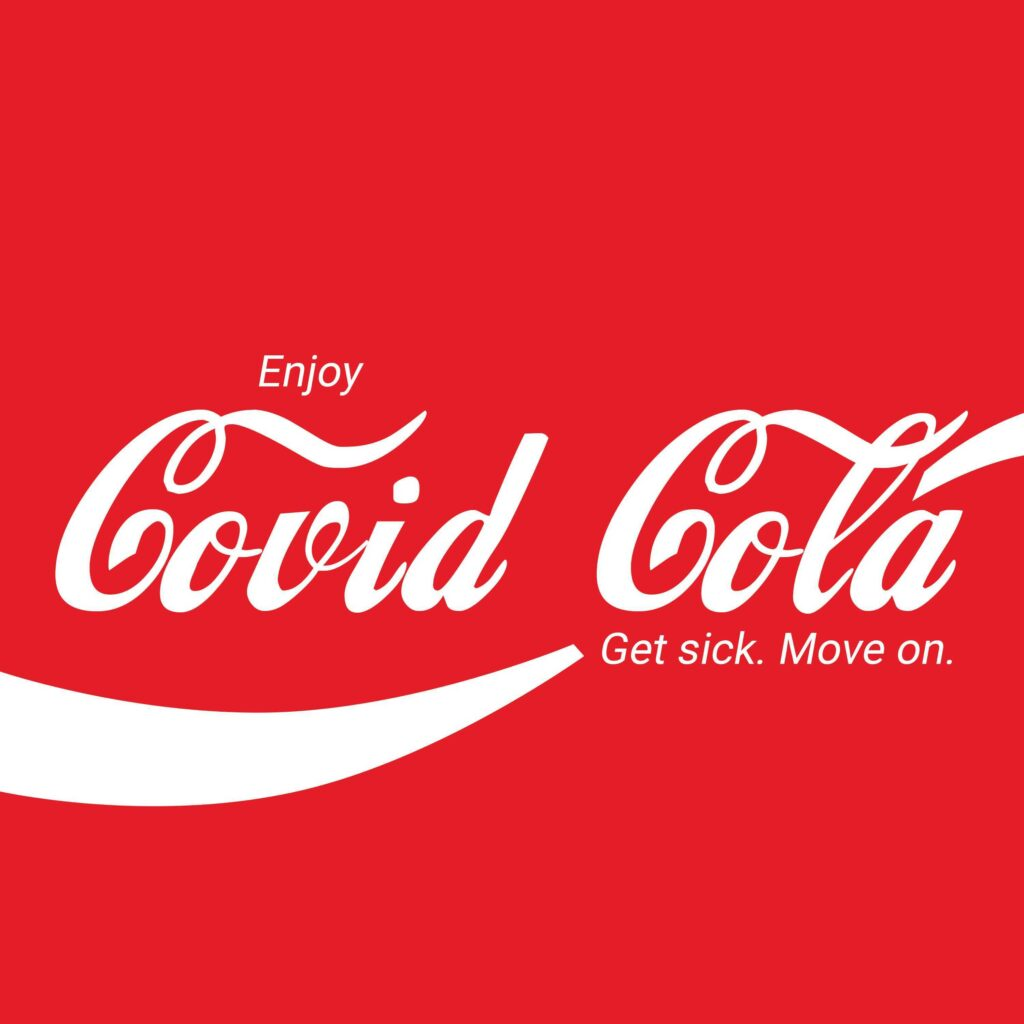

/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


1/1 [==============================] - 0s 110ms/step


'Fake'

In [39]:
image_path = "test.jpg"
img = Image.open(image_path)
display(img)
Classify_image(image_path)